## Imports

In [1]:
import tensorflow as tf
from glob import glob
from os.path import join
from tensorflow.keras import layers, models
import xarray as xr
import pandas as pd
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import imports.GDL_layers as GDL_layers

from time import time

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

2022-12-20 10:29:35.419154: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load data

In [2]:
# Load data
train_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/semifixed_train_data.nc")
validation_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/semifixed_validation_data.nc")
test_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/semifixed_test_data.nc")

In [3]:
input_train = train_ds['ellipse'].expand_dims(dim='channel', axis=-1)
input_train['p'] = np.arange(input_train['p'].shape[0])
output_train = train_ds[['maj_len', 'min_len']].to_array().transpose()
output_train['p'] = np.arange(output_train['p'].shape[0])
input_val = validation_ds['ellipse'].expand_dims(dim='channel', axis=-1)
input_val['p'] = np.arange(input_val['p'].shape[0])
output_val = validation_ds[['maj_len', 'min_len']].to_array().transpose()
output_val['p'] = np.arange(output_val['p'].shape[0])
input_test = test_ds['ellipse'].expand_dims(dim='channel', axis=-1)
input_test['p'] = np.arange(input_test['p'].shape[0])
output_test = test_ds[['maj_len', 'min_len']].to_array().transpose()
output_test['p'] = np.arange(output_test['p'].shape[0])

In [4]:
# Normalize the output data
output_scale_stats = pd.DataFrame(index=range(output_train.shape[-1]), columns=["mean", "sd"])
output_scale_stats.loc[:, "mean"] = output_train.mean(dim="p")
output_scale_stats.loc[:, "sd"] = output_train.std(dim="p")
output_train_norm = xr.DataArray(coords=output_train.coords, dims=output_train.dims)
output_val_norm = xr.DataArray(coords=output_val.coords, dims=output_val.dims)
output_test_norm = xr.DataArray(coords=output_test.coords, dims=output_test.dims)
for i in range(output_train.shape[-1]):
    output_train_norm[:, i] = (output_train[:, i] - output_scale_stats.loc[i, "mean"]) / output_scale_stats.loc[i, "sd"]
    output_val_norm[:, i] = (output_val[:, i] - output_scale_stats.loc[i, "mean"]) / output_scale_stats.loc[i, "sd"]
    output_test_norm[:, i] = (output_test[:, i] - output_scale_stats.loc[i, "mean"]) / output_scale_stats.loc[i, "sd"]

## Train Models

In [5]:
ricnn_models = [models.Sequential() for i in range(6)]
filters = [32, 64, 64, 128]
for inv_layer in range(6):
    ricnn_models[inv_layer].add(GDL_layers.RotEquivConv2D(filters[0], (3, 3), rot_axis=False, input_shape=(128, 128, 1)))
    ricnn_models[inv_layer].add(GDL_layers.RotEquivPool2D((2, 2)))
    if inv_layer == 0:
        ricnn_models[inv_layer].add(GDL_layers.RotInvPool())
    for layer, filts in enumerate(filters):
        if layer < inv_layer:
            ricnn_models[inv_layer].add(GDL_layers.RotEquivConv2D(filters[layer], (3, 3)))
            ricnn_models[inv_layer].add(GDL_layers.RotEquivPool2D((2, 2)))
            if layer + 1 == inv_layer:
                ricnn_models[inv_layer].add(GDL_layers.RotInvPool())
        else:
            ricnn_models[inv_layer].add(layers.Conv2D(filters[layer], (3, 3), activation='relu'))
            ricnn_models[inv_layer].add(layers.MaxPooling2D((2, 2)))
    ricnn_models[inv_layer].add(layers.Flatten())
    ricnn_models[inv_layer].add(layers.Dense(32, activation='relu'))
    ricnn_models[inv_layer].add(layers.Dense(2))
    ricnn_models[inv_layer].compile(
        optimizer='nadam',
        loss='mse'
    )

2022-12-20 10:30:00.034024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 10:30:00.930545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30988 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0


In [6]:
ricnn_history = []
ricnn_test = []
time_history = []
for inv_layer, model in enumerate(ricnn_models):
    model.summary()
    start = time()
    ricnn_history.append(model.fit(x=input_train, y=output_train_norm, epochs=10, validation_data=(input_val, output_val_norm)))
    time_history.append(time() - start)
    print(f'Time elapsed: {time_history[-1]:.3f}')
    ricnn_test.append(model.evaluate(x=input_test, y=output_test_norm))
    model.save(f"saved_models/rot_inv_hyper/inv_layer_{inv_layer}")
    K.clear_session()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d (RotEquivC  (None, 126, 126, 4, 32)  320       
 onv2D)                                                          
                                                                 
 rot_equiv_pool2d (RotEquivP  (None, 63, 63, 4, 32)    0         
 ool2D)                                                          
                                                                 
 rot_inv_pool (RotInvPool)   (None, 63, 63, 32)        0         
                                                                 
 conv2d (Conv2D)             (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                        

2022-12-20 10:30:05.424904: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


313/313 [==============================] - 19s 44ms/step - loss: 0.5929 - val_loss: 0.3451
Epoch 2/10
313/313 [==============================] - 13s 43ms/step - loss: 0.2225 - val_loss: 0.3684
Epoch 3/10
313/313 [==============================] - 13s 42ms/step - loss: 0.0986 - val_loss: 0.1569
Epoch 4/10
313/313 [==============================] - 13s 42ms/step - loss: 0.0688 - val_loss: 0.0764
Epoch 5/10
313/313 [==============================] - 13s 43ms/step - loss: 0.0562 - val_loss: 0.0662
Epoch 6/10
313/313 [==============================] - 13s 43ms/step - loss: 0.0467 - val_loss: 0.0975
Epoch 7/10
313/313 [==============================] - 14s 43ms/step - loss: 0.0400 - val_loss: 0.1076
Epoch 8/10
313/313 [==============================] - 13s 43ms/step - loss: 0.0350 - val_loss: 0.0449
Epoch 9/10
313/313 [==============================] - 13s 43ms/step - loss: 0.0330 - val_loss: 0.0394
Epoch 10/10
313/313 [==============================] - 14s 44ms/step - loss: 0.0297 - val_los

INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_0/assets


INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_0/assets


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d_1 (RotEqui  (None, 126, 126, 4, 32)  320       
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_1 (RotEqui  (None, 63, 63, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_2 (RotEqui  (None, 61, 61, 4, 32)    9248      
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_2 (RotEqui  (None, 30, 30, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_inv_pool_1 (RotInvPool)  (None, 30, 30, 32)      

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.5310WARNING:tensorflow:Keras is training/fitting/evaluating on array-like data. Keras may not be optimized for this format, so if your input data format is supported by TensorFlow I/O (https://github.com/tensorflow/io) we recommend using that to load a Dataset instead.


313/313 [==============================] - 19s 54ms/step - loss: 0.5310 - val_loss: 0.2359
Epoch 2/10
313/313 [==============================] - 17s 53ms/step - loss: 0.1484 - val_loss: 0.0917
Epoch 3/10
313/313 [==============================] - 17s 53ms/step - loss: 0.0804 - val_loss: 0.0787
Epoch 4/10
313/313 [==============================] - 17s 54ms/step - loss: 0.0564 - val_loss: 0.0648
Epoch 5/10
313/313 [==============================] - 17s 53ms/step - loss: 0.0429 - val_loss: 0.0587
Epoch 6/10
313/313 [==============================] - 17s 53ms/step - loss: 0.0345 - val_loss: 0.0605
Epoch 7/10
313/313 [==============================] - 17s 53ms/step - loss: 0.0301 - val_loss: 0.0430
Epoch 8/10
313/313 [==============================] - 17s 53ms/step - loss: 0.0255 - val_loss: 0.1199
Epoch 9/10
313/313 [==============================] - 17s 53ms/step - loss: 0.0236 - val_loss: 0.0354
Epoch 10/10
313/313 [==============================] - 17s 53ms/step - loss: 0.0214 - val_los

32/32 [==============================] - 1s 20ms/step - loss: 0.0350


INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_1/assets


INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_1/assets


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d_3 (RotEqui  (None, 126, 126, 4, 32)  320       
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_3 (RotEqui  (None, 63, 63, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_4 (RotEqui  (None, 61, 61, 4, 32)    9248      
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_4 (RotEqui  (None, 30, 30, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_5 (RotEqui  (None, 28, 28, 4, 64)   

Epoch 1/10
312/313 [============================>.] - ETA: 0s - loss: 0.5304WARNING:tensorflow:Keras is training/fitting/evaluating on array-like data. Keras may not be optimized for this format, so if your input data format is supported by TensorFlow I/O (https://github.com/tensorflow/io) we recommend using that to load a Dataset instead.


313/313 [==============================] - 22s 60ms/step - loss: 0.5300 - val_loss: 0.3908
Epoch 2/10
313/313 [==============================] - 18s 58ms/step - loss: 0.1429 - val_loss: 0.0694
Epoch 3/10
313/313 [==============================] - 18s 58ms/step - loss: 0.0678 - val_loss: 0.0581
Epoch 4/10
313/313 [==============================] - 18s 58ms/step - loss: 0.0471 - val_loss: 0.1547
Epoch 5/10
313/313 [==============================] - 18s 58ms/step - loss: 0.0338 - val_loss: 0.0824
Epoch 6/10
313/313 [==============================] - 18s 58ms/step - loss: 0.0266 - val_loss: 0.0425
Epoch 7/10
313/313 [==============================] - 18s 58ms/step - loss: 0.0208 - val_loss: 0.0197
Epoch 8/10
313/313 [==============================] - 18s 58ms/step - loss: 0.0200 - val_loss: 0.0658
Epoch 9/10
313/313 [==============================] - 18s 58ms/step - loss: 0.0161 - val_loss: 0.0228
Epoch 10/10
313/313 [==============================] - 18s 58ms/step - loss: 0.0159 - val_los

32/32 [==============================] - 1s 21ms/step - loss: 0.0232


INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_2/assets


INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_2/assets


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d_6 (RotEqui  (None, 126, 126, 4, 32)  320       
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_6 (RotEqui  (None, 63, 63, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_7 (RotEqui  (None, 61, 61, 4, 32)    9248      
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_7 (RotEqui  (None, 30, 30, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_8 (RotEqui  (None, 28, 28, 4, 64)   

Epoch 1/10
312/313 [============================>.] - ETA: 0s - loss: 0.5006WARNING:tensorflow:Keras is training/fitting/evaluating on array-like data. Keras may not be optimized for this format, so if your input data format is supported by TensorFlow I/O (https://github.com/tensorflow/io) we recommend using that to load a Dataset instead.


313/313 [==============================] - 23s 61ms/step - loss: 0.5002 - val_loss: 0.3304
Epoch 2/10
313/313 [==============================] - 19s 60ms/step - loss: 0.0973 - val_loss: 0.0370
Epoch 3/10
313/313 [==============================] - 19s 60ms/step - loss: 0.0410 - val_loss: 0.0474
Epoch 4/10
313/313 [==============================] - 19s 60ms/step - loss: 0.0266 - val_loss: 0.0122
Epoch 5/10
313/313 [==============================] - 19s 60ms/step - loss: 0.0222 - val_loss: 0.0188
Epoch 6/10
313/313 [==============================] - 19s 60ms/step - loss: 0.0170 - val_loss: 0.0109
Epoch 7/10
313/313 [==============================] - 19s 59ms/step - loss: 0.0150 - val_loss: 0.0089
Epoch 8/10
313/313 [==============================] - 19s 60ms/step - loss: 0.0130 - val_loss: 0.0144
Epoch 9/10
313/313 [==============================] - 19s 59ms/step - loss: 0.0116 - val_loss: 0.0092
Epoch 10/10
313/313 [==============================] - 19s 60ms/step - loss: 0.0120 - val_los

32/32 [==============================] - 1s 23ms/step - loss: 0.0197


INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_3/assets


INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_3/assets


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d_10 (RotEqu  (None, 126, 126, 4, 32)  320       
 ivConv2D)                                                       
                                                                 
 rot_equiv_pool2d_10 (RotEqu  (None, 63, 63, 4, 32)    0         
 ivPool2D)                                                       
                                                                 
 rot_equiv_conv2d_11 (RotEqu  (None, 61, 61, 4, 32)    9248      
 ivConv2D)                                                       
                                                                 
 rot_equiv_pool2d_11 (RotEqu  (None, 30, 30, 4, 32)    0         
 ivPool2D)                                                       
                                                                 
 rot_equiv_conv2d_12 (RotEqu  (None, 28, 28, 4, 64)   

Epoch 1/10
312/313 [============================>.] - ETA: 0s - loss: 0.4795WARNING:tensorflow:Keras is training/fitting/evaluating on array-like data. Keras may not be optimized for this format, so if your input data format is supported by TensorFlow I/O (https://github.com/tensorflow/io) we recommend using that to load a Dataset instead.


313/313 [==============================] - 24s 62ms/step - loss: 0.4788 - val_loss: 0.0833
Epoch 2/10
313/313 [==============================] - 19s 60ms/step - loss: 0.0787 - val_loss: 0.0207
Epoch 3/10
313/313 [==============================] - 19s 60ms/step - loss: 0.0373 - val_loss: 0.0184
Epoch 4/10
313/313 [==============================] - 19s 60ms/step - loss: 0.0249 - val_loss: 0.0098
Epoch 5/10
313/313 [==============================] - 19s 60ms/step - loss: 0.0185 - val_loss: 0.0289
Epoch 6/10
313/313 [==============================] - 19s 61ms/step - loss: 0.0160 - val_loss: 0.0160
Epoch 7/10
313/313 [==============================] - 19s 60ms/step - loss: 0.0137 - val_loss: 0.0172
Epoch 8/10
313/313 [==============================] - 19s 60ms/step - loss: 0.0121 - val_loss: 0.0116
Epoch 9/10
313/313 [==============================] - 19s 60ms/step - loss: 0.0108 - val_loss: 0.0224
Epoch 10/10
313/313 [==============================] - 19s 60ms/step - loss: 0.0102 - val_los

32/32 [==============================] - 1s 23ms/step - loss: 0.0068
INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_4/assets


INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_4/assets


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d_15 (RotEqu  (None, 126, 126, 4, 32)  320       
 ivConv2D)                                                       
                                                                 
 rot_equiv_pool2d_15 (RotEqu  (None, 63, 63, 4, 32)    0         
 ivPool2D)                                                       
                                                                 
 rot_equiv_conv2d_16 (RotEqu  (None, 61, 61, 4, 32)    9248      
 ivConv2D)                                                       
                                                                 
 rot_equiv_pool2d_16 (RotEqu  (None, 30, 30, 4, 32)    0         
 ivPool2D)                                                       
                                                                 
 rot_equiv_conv2d_17 (RotEqu  (None, 28, 28, 4, 64)   

Epoch 1/10
312/313 [============================>.] - ETA: 0s - loss: 0.5229WARNING:tensorflow:Keras is training/fitting/evaluating on array-like data. Keras may not be optimized for this format, so if your input data format is supported by TensorFlow I/O (https://github.com/tensorflow/io) we recommend using that to load a Dataset instead.


313/313 [==============================] - 24s 63ms/step - loss: 0.5223 - val_loss: 0.2442
Epoch 2/10
313/313 [==============================] - 19s 62ms/step - loss: 0.0829 - val_loss: 0.0551
Epoch 3/10
313/313 [==============================] - 19s 61ms/step - loss: 0.0433 - val_loss: 0.0732
Epoch 4/10
313/313 [==============================] - 19s 61ms/step - loss: 0.0275 - val_loss: 0.0276
Epoch 5/10
313/313 [==============================] - 19s 61ms/step - loss: 0.0221 - val_loss: 0.0178
Epoch 6/10
313/313 [==============================] - 19s 61ms/step - loss: 0.0165 - val_loss: 0.0102
Epoch 7/10
313/313 [==============================] - 19s 61ms/step - loss: 0.0141 - val_loss: 0.0809
Epoch 8/10
313/313 [==============================] - 19s 61ms/step - loss: 0.0156 - val_loss: 0.0101
Epoch 9/10
313/313 [==============================] - 19s 62ms/step - loss: 0.0114 - val_loss: 0.0074
Epoch 10/10
313/313 [==============================] - 19s 61ms/step - loss: 0.0116 - val_los

32/32 [==============================] - 1s 23ms/step - loss: 1.2780
INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_5/assets


INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_5/assets


In [7]:
print(ricnn_test)
print(time_history)

[0.039537616074085236, 0.03501706197857857, 0.023247024044394493, 0.019677700474858284, 0.006801065988838673, 1.2780100107192993]
[139.951336145401, 169.2742154598236, 184.56054663658142, 191.11355328559875, 193.60147333145142, 196.3232388496399]


(0.0, 0.6222683008760214)

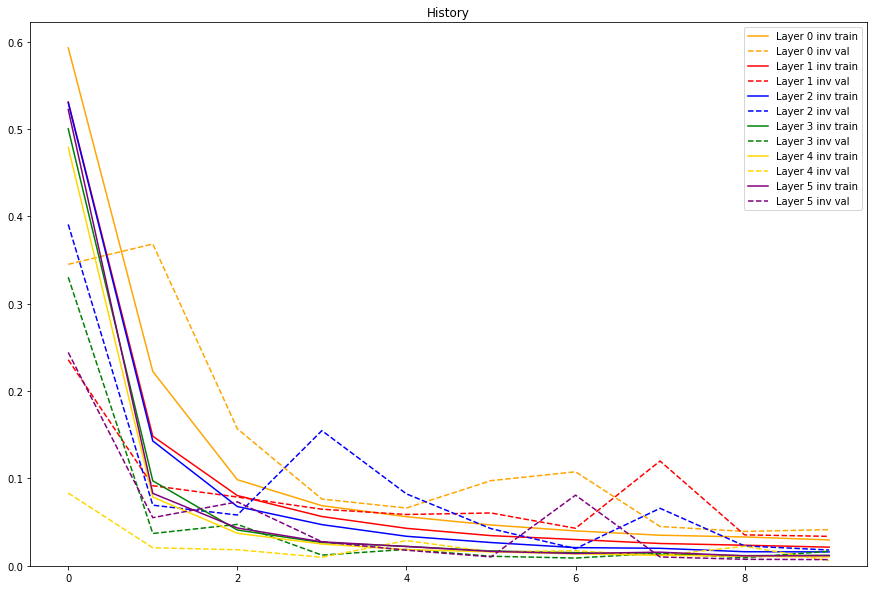

In [8]:
F, ax = plt.subplots(1, 1, figsize=(15, 10))
colors = ['orange', 'red', 'blue', 'green', 'gold', 'purple']
for i in range(6):
    ax.plot(ricnn_history[i].history['loss'], color=colors[i], label = f'Layer {i} inv train')
    ax.plot(ricnn_history[i].history['val_loss'], color=colors[i], label = f'Layer {i} inv val', linestyle='dashed')
plt.legend()
ax.set_title("History")
ax.set_ylim(bottom=0)